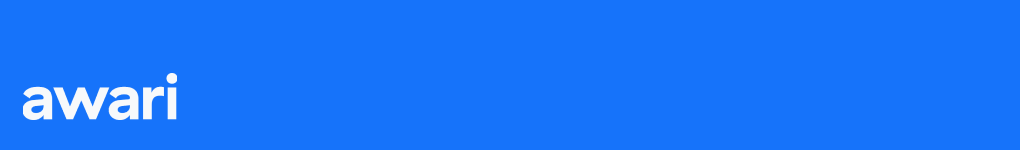

---

In [ ]:
!pip install boto3

import pyspark
import boto3

from io import StringIO 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains

# Criando um contexto

In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession

# Criando uma sessão com o Spark que existe localmente(atualmente configurado junto com o JupyterLab)
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("awariDE") \
      .getOrCreate() 

# Criando um RDD
- Resilient Distributed Datasets, abstraem um conjunto de objetos distribuídos no cluster, geralmente executados na memória principal e podem depois serem salvos em um Haddop, Banco de Datos, arquivo, etc, quando você carrega 
- Um RDD ele é um dado IMUTAVEL e e semelhante a uma lista em Python, com a diferença de que o RDD é calculado em vários processos espalhados por vários servidores físicos, também chamados de nós em um cluster, enquanto uma coleção Python vive e processa em apenas um processo.
- RDD é mais utilizado quando precisamos trabalhar mais baixo nivel manipulando diretamente o DataSet

In [ ]:
# A Partir de um arquivo
rdd2 = spark.sparkContext.textFile("./arquivos/customers.csv")
header = rdd2.first()
rdd2 = rdd2.filter(lambda row: row != header)
rdd2.take(5)

# RDD Operações
Transformações no Spark etorna outro RDD e essas transformações são lentas, o que significa que elas não são executadas até que você chame uma ação no RDD. Algumas transformações em RDD's são flatMap(), map(), reduceByKey(), filter(), sortByKey() e retornam um novo RDD ao invés de atualizar o atual.

# RDD Ações
Retorna os valores de um RDD para um nó de driver. Em outras palavras, qualquer função RDD que retorna um não RDD é considerada uma ação. Algumas ações no RDD são count(), collect(), first(), max(), reduce() and more.

# PySpark DataFrame
DataFrame é uma coleção distribuída de dados organizados em colunas nomeadas. É conceitualmente equivalente a uma tabela em um banco de dados relacional ou um quadro de dados em R/Python, mas com otimizações mais ricas sob o capô. Os DataFrames podem ser construídos a partir de uma ampla variedade de fontes, como arquivos de dados estruturados, tabelas no Hive, bancos de dados externos ou RDDs existentes. Diferente do RDD é mais utilizado para analise de dados, debugs, etc.

In [ ]:
# Criando um DataFrame
data = [('James','','Smith','1991-04-01','M',3000),
  ('Michael','Rose','','2000-05-19','M',4000),
  ('Robert','','Williams','1978-09-05','M',4000),
  ('Maria','Anne','Jones','1967-12-01','F',4000),
  ('Jen','Mary','Brown','1980-02-17','F',-1)
]

columns = ["firstname","middlename","lastname","dob","gender","salary"]
df = spark.createDataFrame(data=data, schema = columns)
print(df.show(), df.printSchema())

In [ ]:
# Lendo um arquivo
df = spark.read.option("header", True).csv("./arquivos/customers.csv")
print(df.show(), df.printSchema())

# Usando SQL

In [ ]:
df.createOrReplaceTempView("CUSTOMERS")
df2 = spark.sql("SELECT * from CUSTOMERS LIMIT 5")
print(df2.show(), df2.printSchema())

In [ ]:
# Usando GROUPBY
groupDF = spark.sql("SELECT Profession, count(*) as total from CUSTOMERS group by Profession")
groupDF.show()

In [ ]:
spark.stop()

# Salvando dados no MinIO
Criar o bucket aula-spark no MinIO

In [ ]:
conf = pyspark.SparkConf()

# Criando uma sessão com o Spark que existe localmente(atualmente configurado junto com o JupyterLab)
conf.setMaster("local[1]") 
conf.set("spark.driver.host", "awari-jupyterlab") \
    .set("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol") \
    .set("parquet.enable.summary-metadata", "false") \
    .set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false") \
    .set("spark.driver.port", "20020") \
    .set("spark.hadoop.fs.s3a.endpoint", 'awari-nginx:9000') \
    .set("spark.hadoop.fs.s3a.endpoint.region", 'sa-east-1') \
    .set("spark.hadoop.fs.s3a.access.key", 'mnYOiUf07UBjjJwf') \
    .set("spark.hadoop.fs.s3a.secret.key", '1Qu7X3EmbIYDNXUiuvFSDUJwJ4fWdyT5') \
    .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .set("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .set("spark.hadoop.com.amazonaws.services.s3.enableV2", "true") \
    .set("spark.hadoop.fs.s3a.committer.staging.conflict-mode", "replace") \
    .set("spark.hadoop.fs.s3a.fast.upload", True) \
    .set("spark.hadoop.fs.s3a.path.style.access", True) \
    .set("spark.hadoop.fs.s3a.committer.name", "directory") \
    .set("spark.hadoop.fs.s3a.committer.staging.tmp.path", "/tmp/staging")

conf.setAppName('awariDES3')
sc = pyspark.SparkContext(conf=conf)

spark = SparkSession(sc)

In [ ]:
client = boto3.client('s3', 
    endpoint_url='http://awari-minio-nginx:9000',
    aws_access_key_id='mnYOiUf07UBjjJwf',
    aws_secret_access_key='1Qu7X3EmbIYDNXUiuvFSDUJwJ4fWdyT5',
    aws_session_token=None,
    config=boto3.session.Config(signature_version='s3v4'),
    verify=False,
    region_name='sa-east-1'
)

In [ ]:
df = spark.read.option("header", True).csv("s3a://aula-spark/resources/usuarios.csv")
print(df.show(), df.printSchema())

In [ ]:
# Usando RDD
# A Partir de um arquivo
rdd3 = spark.sparkContext.textFile("s3a://aula-spark/resources/usuarios.csv")
rdd3 = rdd3.map(lambda f: f.split(","))
header = rdd3.first()

rdd3 = rdd3.filter(lambda row: row != header)
rdd3 = sc.parallelize(rdd3.collect())
df = rdd3.toDF(header)
df.show()

In [ ]:
# Convertendo CSV para PARQUET e salvando no storage
df.write.save("s3a://aula-spark/meu-parquet")

In [ ]:
# Lendo um parquet file
parDF1=spark.read.parquet("s3a://aula-spark/meu-parquet")
parDF1.first()

---

Notebook utilizado para fins educacionais da **Awari**.

**© AWARI. Todos os direitos reservados.**